In [1]:
import numpy as np

In [2]:
data = np.load('./data/dataset-v3.npz')
np.unique(data['labels'])

array([0, 1, 2, 3, 4, 5, 6])

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
train_images, test_images, train_labels, test_labels = train_test_split(data['data'], data['labels'], test_size=0.30, stratify=data['labels'])

In [5]:
len_test = len(test_labels)
len_train = len(train_labels)
print(len_test, len_train)

607 1416


In [6]:
train_images.shape

(1416, 50, 370)

In [7]:
import matplotlib.pyplot as plt

In [8]:
index = 22
item = train_images[index]
print('Result:', train_labels[index])

Result: 2


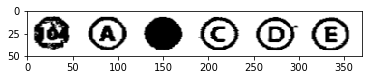

In [9]:
plt.imshow(item, cmap=plt.cm.binary_r)
plt.show()

In [10]:
from keras.utils import to_categorical

/home/kleber/anaconda3/envs/tensorflow-cpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/kleber/anaconda3/envs/tensorflow-cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [11]:
train_images = train_images.reshape((len_train, 50, 370, 1))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((len_test, 50, 370, 1))
test_images = test_images.astype('float32') / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [15]:
from keras import layers
from keras import models
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

def create_model(layers_out=[32,64,64,128], activation='relu', last_activation='softmax', optimizer='rmsprop', conv_map=[(16, 16), (8, 8), (4, 4)], dropout=.1):
    model = models.Sequential()
    
    model.add(layers.Conv2D(layers_out[0], conv_map[0], activation=activation, input_shape=(50, 370, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Conv2D(layers_out[1], conv_map[1], activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Conv2D(layers_out[2], conv_map[2], activation=activation))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Flatten())    
    model.add(layers.Dense(layers_out[3], activation=activation))    
    
    model.add(layers.Dense(7, activation=last_activation))
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
model = KerasClassifier(build_fn=create_model, verbose=2)

epochs = [3]
batch_size = [8]
#layers_out = [[32,64,64,128],[128,64,64,32], [64,32,32,64], [64,32,16,64]]
#activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
#last_activation = ['softmax', 'sigmoid', 'hard_sigmoid', 'linear']
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#dropout = [0, .1, .2, .3]
#conv_map = [[(16, 16), (8, 8), (4, 4)], [(8, 8), (4, 4), (2, 2)]]

param_grid = dict(batch_size=batch_size, 
                  epochs=epochs, 
                  #layers_out=layers_out,
                  #activation=activation,
                  #last_activation=last_activation,
                  optimizer=optimizer,
                  #dropout=dropout,
                  #conv_map=conv_map
                 )

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=4)

#model.fit(train_images, train_labels, epochs=20, batch_size=16, validation_data=(test_images, test_labels))

In [21]:
grid_result = grid.fit(train_images, train_labels)

Epoch 1/3
Epoch 1/3
Epoch 1/3
Epoch 1/3


KeyboardInterrupt: 

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
from keras.models import model_from_json
import os

In [ ]:
model_json = model.to_json()
with open('./model/covnet-questions-v3.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
model.save_weights('./model/covnet-questions-v3.h5')